In [26]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [28]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [29]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [30]:
tf.keras.backend.clear_session()

In [31]:
subject = 'Pará - Consumo de Cimento (t)'
start_index = 0
split_index = 155
window_size = 36
train_split = split_index + 1 - 12

In [32]:
data = pd.read_csv('2003_mo_model_input_PA.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Pará - IDH Educacao,Pará - Desemprego,Pará - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Pará - Produção de Cimento (t),Pará - Consumo de Cimento (t),Pará - value,Pará - IDH Longevidade,Pará- custo m2 (R$),Pará - IDH Renda,Pará - IDH,Pará - PIB - Estadual,Pará - PIB - Construção Civil,Pará - PIB - Per Capita,Pará - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,0.614461,8.348543,2.208327e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.618560,84.701,0.312867,0.748453,10387.404000,0.648977,0.669564,7.776091e+07,4.250430e+06,9.220374,6.851269e+07,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,0.614718,8.342554,2.222364e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.658098,80.221,0.312657,0.748776,10470.519385,0.649037,0.669764,7.787181e+07,4.255476e+06,9.225493,6.856365e+07,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,0.614976,8.336566,2.236400e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.906876,76.122,0.311736,0.749099,10546.359385,0.649097,0.669963,7.798271e+07,4.260521e+06,9.230612,6.861461e+07,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,0.615233,8.330578,2.250437e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.864305,76.544,0.310493,0.749421,10614.915813,0.649156,0.670163,7.809361e+07,4.265566e+06,9.235731,6.866557e+07,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,0.615490,8.324589,2.264474e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.179753,83.445,0.309128,0.749744,10682.772020,0.649216,0.670362,7.820451e+07,4.270611e+06,9.240851,6.871652e+07,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36200.254402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36157.819932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36097.250375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36021.389035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


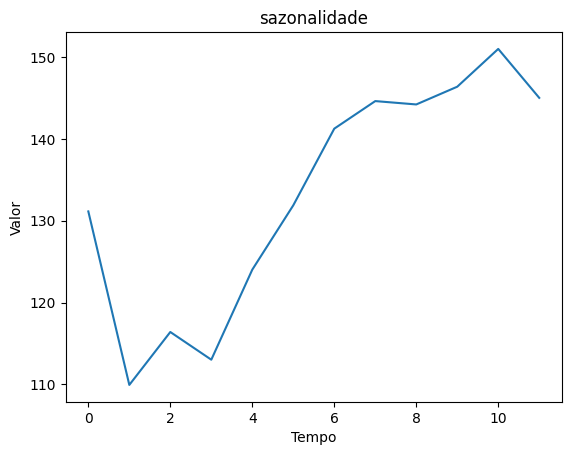

,sazonalidade
sazonalidade,
0,131.129240
1,109.929373
2,116.395769
3,113.011535
4,124.014100
5,131.874479
6,141.240653
7,144.608931
8,144.198593


In [33]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [34]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Pará - IDH Educacao,Pará - Desemprego,Pará - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Pará - Produção de Cimento (t),Pará - value,Pará - IDH Longevidade,Pará- custo m2 (R$),Pará - IDH Renda,Pará - IDH,Pará - PIB - Estadual,Pará - PIB - Construção Civil,Pará - PIB - Per Capita,Pará - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Pará - Consumo de Cimento (t)
0,2003-1,0.614461,8.348543,2.208327e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.618560,0.312867,0.748453,10387.404000,0.648977,0.669564,7.776091e+07,4.250430e+06,9.220374,6.851269e+07,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,131.129240,84.701
1,2003-2,0.614718,8.342554,2.222364e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.658098,0.312657,0.748776,10470.519385,0.649037,0.669764,7.787181e+07,4.255476e+06,9.225493,6.856365e+07,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,109.929373,80.221
2,2003-3,0.614976,8.336566,2.236400e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.906876,0.311736,0.749099,10546.359385,0.649097,0.669963,7.798271e+07,4.260521e+06,9.230612,6.861461e+07,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,116.395769,76.122
3,2003-4,0.615233,8.330578,2.250437e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.864305,0.310493,0.749421,10614.915813,0.649156,0.670163,7.809361e+07,4.265566e+06,9.235731,6.866557e+07,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,113.011535,76.544
4,2003-5,0.615490,8.324589,2.264474e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.179753,0.309128,0.749744,10682.772020,0.649216,0.670362,7.820451e+07,4.270611e+06,9.240851,6.871652e+07,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,124.014100,83.445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36200.254402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124.014100,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36157.819932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,131.874479,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36097.250375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,141.240653,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36021.389035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144.608931,NaN


In [35]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      115.365
1       90.229
2       87.897
3       96.273
4       97.686
        ...   
244        NaN
245        NaN
246        NaN
247        NaN
248        NaN
Name: Pará - Consumo de Cimento (t), Length: 249, dtype: float64

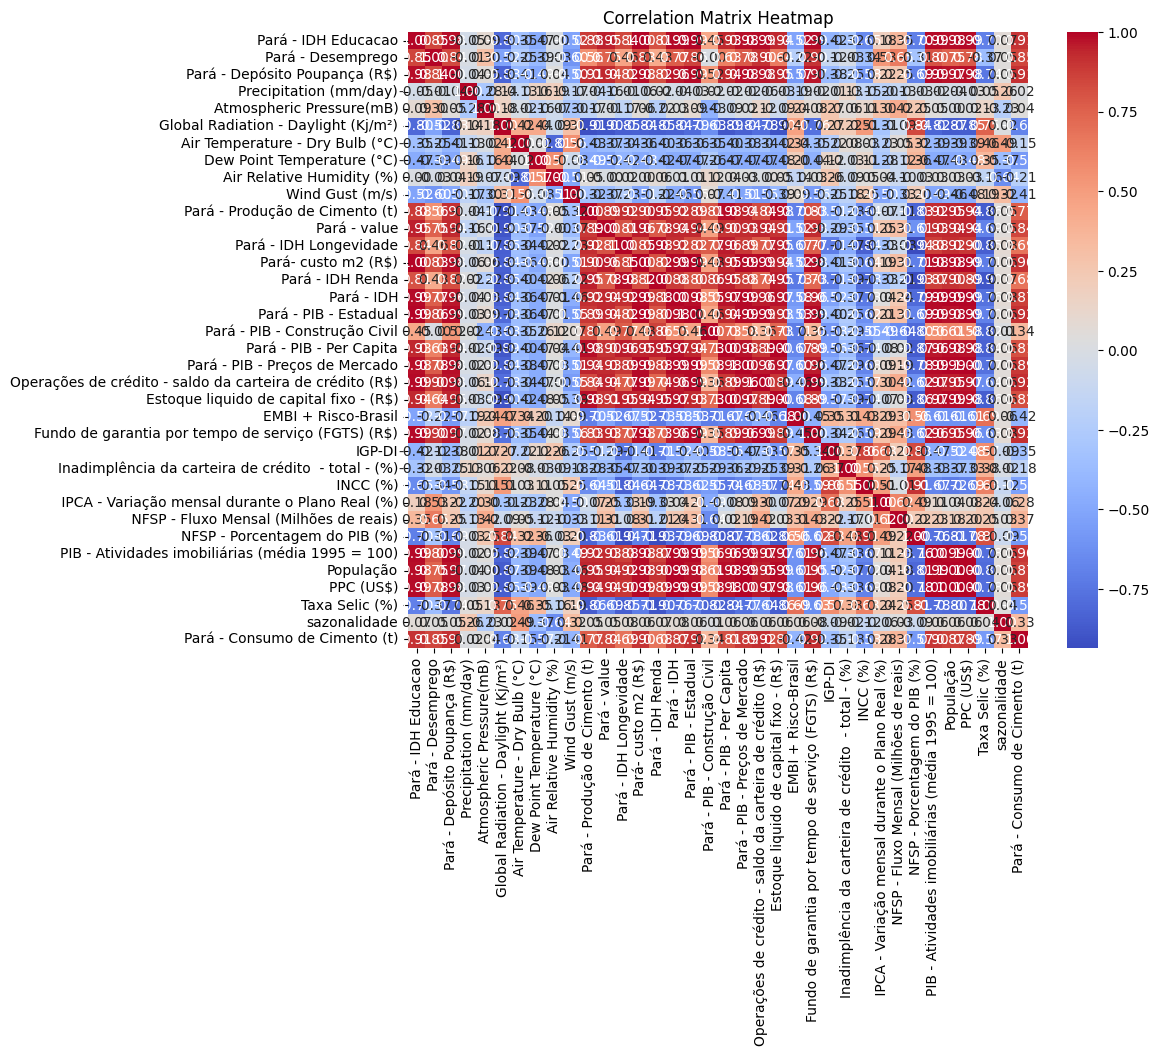

In [36]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [38]:
safe_data = data.fillna(0.0).iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Pará - IDH Educacao,1.570939e+10
1,Pará - Desemprego,5.572173e+04
2,Pará - Depósito Poupança (R$),1.816889e+05
3,Precipitation (mm/day),2.346988e+02
4,Atmospheric Pressure(mB),2.718674e+06
5,Global Radiation - Daylight (Kj/m²),1.706961e+02
6,Air Temperature - Dry Bulb (°C),3.518516e+06
7,Dew Point Temperature (°C),2.387662e+06
8,Air Relative Humidity (%),1.696680e+06
9,Wind Gust (m/s),4.447333e+02


In [39]:
data =data.fillna(0.0).drop(['Air Temperature - Dry Bulb (°C)',
                 'Precipitation (mm/day)',
                 'Global Radiation - Daylight (Kj/m²)', 
                 'Air Relative Humidity (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 1000000)
data

Num columns removed: 10


,Pará - Desemprego,Pará - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Pará - Produção de Cimento (t),Pará - value,Pará- custo m2 (R$),Pará - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,8.348543,2.208327e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49.618560,0.312867,10387.404000,4.250430e+06,3.846831e+05,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,169.247665,1.611498,131.129240
1,8.342554,2.222364e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49.658098,0.312657,10470.519385,4.255476e+06,3.852662e+05,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,170.176810,1.450389,109.929373
2,8.336566,2.236400e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49.906876,0.311736,10546.359385,4.260521e+06,3.853051e+05,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,171.135713,1.870184,116.395769
3,8.330578,2.250437e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49.864305,0.310493,10614.915813,4.265566e+06,3.857521e+05,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,172.116904,1.355287,113.011535
4,8.324589,2.264474e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.179753,0.309128,10682.772020,4.270611e+06,3.871640e+05,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,173.072271,1.585538,124.014100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,10.566862,5.619851e+06,2.985062,1009.342000,1195.006090,22.500915,76.054439,0.850310,115.327594,0.470827,22264.636134,4.352069e+06,3.143856e+06,336.843217,9.124085e+06,0.471500,3.103302,0.501878,0.527374,-1005.696691,2.438647,192.698092,390.589413,1.078474,144.608931
152,10.571085,5.585310e+06,2.935553,1009.118673,1198.351423,22.488955,75.470110,0.831561,114.918907,0.472176,22373.035751,4.345660e+06,3.159665e+06,345.939329,9.111628e+06,0.475422,3.177535,0.489257,0.525404,-1039.159506,2.375528,192.754385,391.798431,0.962516,144.198593
153,10.575308,5.550768e+06,2.929306,1008.918683,1170.901815,22.631244,75.975035,0.816221,114.521362,0.473503,22480.287142,4.339251e+06,3.177292e+06,356.198303,9.630300e+06,0.447600,3.254167,0.489071,0.522000,-1243.715598,2.307250,192.810678,393.032398,1.138989,146.365168
154,10.579530,5.516227e+06,3.089585,1008.768513,1115.574004,22.810586,77.625668,0.781123,114.391330,0.474526,22569.632926,4.332842e+06,3.192250e+06,363.318059,1.020613e+07,0.426394,3.330340,0.486059,0.509714,-1329.246736,2.242645,192.715004,394.326420,1.038436,150.983090


In [40]:
input_data = data.fillna(0.0).iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Pará - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Pará - Produção de Cimento (t),Pará - value,Pará- custo m2 (R$),Pará - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,-1.417668,-3.097618,-3.464092,-0.866016,-3.458055,-3.438129,-2.655843,-1.735527,-0.813709,-1.538649,-2.163198,-1.219223,-0.510608,-1.245444,3.807189,1.508986,3.557039,2.744724,0.791200,4.007134,-1.745295,-1.737578,2.007617
1,-1.406979,-3.097618,-3.464092,-0.866016,-3.458055,-3.438129,-2.655843,-1.734112,-0.816992,-1.515802,-2.108144,-1.218580,-0.710802,-1.285329,3.466444,1.502979,3.362807,2.328463,0.796512,3.841816,-1.739636,-1.724415,1.464013
2,-1.396289,-3.097618,-3.464092,-0.866016,-3.458055,-3.438129,-2.655843,-1.725205,-0.831369,-1.494955,-2.053091,-1.218537,-0.544025,-1.300726,3.304873,1.501477,3.234624,2.074077,0.748042,3.657082,-1.733978,-1.710831,2.880457
3,-1.385600,-3.097618,-3.464092,-0.866016,-3.458055,-3.438129,-2.655843,-1.726729,-0.850775,-1.476111,-1.998037,-1.218044,-0.101360,-1.304485,3.047593,1.499141,3.111793,1.960720,0.637207,3.455390,-1.728320,-1.696931,1.143128
4,-1.374911,-3.097618,-3.464092,-0.866016,-3.458055,-3.438129,-2.655843,-1.715436,-0.872079,-1.457459,-1.942983,-1.216487,0.484338,-1.295677,2.865728,1.487539,3.372081,1.810716,0.681319,3.226068,-1.721344,-1.683397,1.920025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,1.180313,0.140704,0.291056,-0.660742,0.206520,0.096535,-0.183834,0.616867,1.652018,1.726130,-1.054101,1.823582,0.414233,1.659621,-0.661498,-0.418507,-1.258759,0.318154,2.562832,-0.538499,1.326731,1.398025,0.209123
152,1.154009,0.086994,0.290225,-0.660167,0.204572,0.069378,-0.238342,0.602236,1.673081,1.755927,-1.124037,1.841017,0.494098,1.654471,-0.630482,-0.159821,-1.388696,0.293838,2.549126,-0.570093,1.329342,1.415152,-0.182135
153,1.127704,0.080217,0.289481,-0.664882,0.227746,0.092845,-0.282938,0.588003,1.693787,1.785408,-1.193974,1.860456,0.584174,1.868895,-0.850517,0.107226,-1.390613,0.251845,2.465341,-0.604269,1.331953,1.432633,0.413308
154,1.101400,0.254094,0.288923,-0.674386,0.256954,0.169558,-0.384975,0.583348,1.709767,1.809967,-1.263910,1.876950,0.646687,2.106951,-1.018234,0.372672,-1.421626,0.100243,2.430308,-0.636606,1.327515,1.450965,0.074029


In [41]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Pará - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Pará - Produção de Cimento (t),Pará - value,Pará- custo m2 (R$),Pará - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,-1.417668,-3.097618,-3.464092,-0.866016,-3.458055,-3.438129,-2.655843,-1.735527,-0.813709,-1.538649,-2.163198,-1.219223,-0.510608,-1.245444,3.807189,1.508986,3.557039,2.744724,0.791200,4.007134,-1.745295,-1.737578,2.007617
1,-1.406979,-3.097618,-3.464092,-0.866016,-3.458055,-3.438129,-2.655843,-1.734112,-0.816992,-1.515802,-2.108144,-1.218580,-0.710802,-1.285329,3.466444,1.502979,3.362807,2.328463,0.796512,3.841816,-1.739636,-1.724415,1.464013
2,-1.396289,-3.097618,-3.464092,-0.866016,-3.458055,-3.438129,-2.655843,-1.725205,-0.831369,-1.494955,-2.053091,-1.218537,-0.544025,-1.300726,3.304873,1.501477,3.234624,2.074077,0.748042,3.657082,-1.733978,-1.710831,2.880457
3,-1.385600,-3.097618,-3.464092,-0.866016,-3.458055,-3.438129,-2.655843,-1.726729,-0.850775,-1.476111,-1.998037,-1.218044,-0.101360,-1.304485,3.047593,1.499141,3.111793,1.960720,0.637207,3.455390,-1.728320,-1.696931,1.143128
4,-1.374911,-3.097618,-3.464092,-0.866016,-3.458055,-3.438129,-2.655843,-1.715436,-0.872079,-1.457459,-1.942983,-1.216487,0.484338,-1.295677,2.865728,1.487539,3.372081,1.810716,0.681319,3.226068,-1.721344,-1.683397,1.920025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1.418439,0.018511,0.291482,-0.651509,0.220801,0.193611,-0.475546,0.730123,1.310282,1.358294,-0.238187,1.517172,-0.364905,1.409149,0.519146,-0.961354,-0.690123,1.744343,1.792831,-0.357756,1.345611,1.245801,-0.282621
140,1.407640,0.084382,0.290100,-0.648328,0.211810,0.147745,-0.357029,0.719980,1.350072,1.387569,-0.303460,1.549848,-0.347187,1.422197,0.540645,-1.047598,-0.646253,1.739673,1.807843,-0.353467,1.346023,1.254608,-0.612121
141,1.396841,0.063794,0.289318,-0.652849,0.215660,0.154458,-0.368681,0.710010,1.383487,1.421810,-0.368732,1.588878,-0.321619,1.608476,0.589758,-1.189483,-0.641003,1.698689,1.374436,-0.355172,1.346436,1.263636,-0.137902
142,1.386042,0.115541,0.288904,-0.659349,0.223811,0.176742,-0.298198,0.700007,1.414153,1.452724,-0.434004,1.625721,-0.287493,1.830253,0.536404,-1.332682,-0.650191,1.675167,1.652790,-0.359681,1.337260,1.272935,-0.332143


In [42]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      115.365000
1       90.229000
2       87.897000
3       96.273000
4       97.686000
          ...    
139    176.264718
140    175.518039
141    179.465921
142    179.080273
143    149.257000
Name: Pará - Consumo de Cimento (t), Length: 144, dtype: float64

In [43]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [44]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(108, 36, 23)

In [45]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Pará - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Pará - Produção de Cimento (t),Pará - value,Pará- custo m2 (R$),Pará - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
108,0.797767,0.477645,0.285879,-0.665520,0.244724,0.357392,-0.133073,1.206531,0.617572,0.706219,1.213641,0.595959,-0.758140,0.735654,-0.150121,1.452528,-0.134638,-0.348558,-1.286705,-0.712725,0.693264,0.812014,-1.082183
109,0.834360,0.311584,0.286599,-0.667795,0.251128,0.382915,-0.259592,1.193343,0.620344,0.724396,1.182005,0.621380,-0.744935,0.632719,-0.064049,1.577437,-0.250541,-0.314756,-1.091776,-0.707406,0.732176,0.831569,-1.036767
110,0.870954,0.399861,0.288198,-0.668395,0.257174,0.392311,-0.389061,1.193296,0.620306,0.742580,1.150369,0.652999,-0.743509,0.633437,0.165323,1.665230,-0.253852,-0.193331,-1.072106,-0.699231,0.771088,0.850791,-0.752482
111,0.907548,0.197750,0.289291,-0.665815,0.254496,0.373571,-0.439308,1.188467,0.620660,0.760305,1.118733,0.685630,-0.748471,0.610450,0.155491,1.735648,-0.175858,-0.069191,-1.161345,-0.693507,0.810000,0.868783,-1.088413
112,0.944141,0.210098,0.291036,-0.659994,0.234922,0.329917,-0.346335,1.190923,0.620843,0.777632,1.087097,0.717515,-0.764308,0.631167,-0.075593,1.739412,0.099226,-0.104407,-0.961650,-0.679000,0.850727,0.886720,-1.508135
113,0.980735,0.489643,0.292387,-0.654918,0.222206,0.292795,-0.224828,1.187901,0.622118,0.794901,1.055461,0.747579,-0.786416,0.659533,-0.323610,1.747279,-0.153882,-0.083975,-0.938217,-0.662783,0.891455,0.905151,-1.474280
114,1.017329,0.369582,0.291663,-0.646541,0.208484,0.234835,-0.046296,1.186011,0.622385,0.811797,1.023826,0.775262,-0.808518,0.667761,-0.525659,1.756575,-0.146871,-0.089130,-0.921820,-0.650682,0.932183,0.923702,-1.463452
115,1.053922,0.556265,0.290896,-0.638831,0.196075,0.165847,0.209489,1.172097,0.624936,0.828705,0.992190,0.805205,-0.838953,0.689072,-0.771574,1.787886,-0.265940,-0.124447,-0.813396,-0.648019,0.969967,0.942382,-1.236037
116,1.090516,0.804904,0.289051,-0.639127,0.204281,0.161920,0.241277,1.153475,0.633739,0.844971,0.960554,0.836796,-0.869366,0.684945,-0.995926,1.740250,-0.285762,-0.077195,-0.692727,-0.640313,1.007752,0.960385,-0.935721
117,1.127109,0.609916,0.287482,-0.644186,0.227155,0.187531,0.117724,1.145101,0.645740,0.864587,0.928918,0.876422,-0.900682,0.852584,-1.066619,1.618503,-0.293773,-0.110139,-0.644199,-0.639749,1.045536,0.977769,-1.241995


In [46]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 23)

In [47]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(180, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[84767235, 1610665753, 2748378690, 486986329, 414367064, 1876686271, 4176967860, 314544899, 999198064, 3472876283]


Step: 0 ___________________________________________
val_loss: 241.11544799804688
winner_seed: 84767235


Step: 1 ___________________________________________
val_loss: 178.97935485839844
winner_seed: 1610665753


Step: 2 ___________________________________________
val_loss: 313.18878173828125


Step: 3 ___________________________________________
val_loss: 176.21905517578125
winner_seed: 486986329


Step: 4 ___________________________________________
val_loss: 1.4910788346060997e+19


Step: 5 ___________________________________________
val_loss: 109.76661682128906
winner_seed: 1876686271


Step: 6 ___________________________________________
val_loss: 141.58340454101562


Step: 7 ___________________________________________
val_loss: 1.8338348699689425e+25


Step: 8 ___________________________________________
val_loss: 118.2592544555664


Step: 9 ____________________________

In [51]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 1595719333

Epoch 1/10000
4/4 [==============================] - 2s 262ms/step - loss: 21476.6934 - val_loss: 248.5358
Epoch 2/10000
4/4 [==============================] - 0s 8ms/step - loss: 1335.5579 - val_loss: 1530.8785
Epoch 3/10000
4/4 [==============================] - 0s 8ms/step - loss: 1416.1210 - val_loss: 195.9549
Epoch 4/10000
4/4 [==============================] - 0s 8ms/step - loss: 1350.0709 - val_loss: 121.9905
Epoch 5/10000
4/4 [==============================] - 0s 8ms/step - loss: 1275.2015 - val_loss: 1463.6710
Epoch 6/10000
4/4 [==============================] - 0s 8ms/step - loss: 1671.3940 - val_loss: 387.3562
Epoch 7/10000
4/4 [==============================] - 0s 8ms/step - loss: 1429.9414 - val_loss: 1149.6331
Epoch 8/10000
4/4 [==============================] - 0s 8ms/step - loss: 1256.9886 - val_loss: 710.9677
Epoch 9/10000
4/4 [==============================] - 0s 7ms/step - loss: 1471.0256 - val_loss: 185.9546
Epoch 10/10000
4/4 [==============================] - 0s 8

4/4 [==============================] - 0s 10ms/step - loss: 657.4307 - val_loss: 330.0812
Epoch 80/10000
4/4 [==============================] - 0s 9ms/step - loss: 300.2679 - val_loss: 189.0224
Epoch 81/10000
4/4 [==============================] - 0s 8ms/step - loss: 586.9185 - val_loss: 594.1737
Epoch 82/10000
4/4 [==============================] - 0s 8ms/step - loss: 365.7304 - val_loss: 1227.8667
Epoch 83/10000
4/4 [==============================] - 0s 8ms/step - loss: 479.9969 - val_loss: 922.9014
Epoch 84/10000
4/4 [==============================] - 0s 9ms/step - loss: 320.6185 - val_loss: 162.8358
Epoch 85/10000
4/4 [==============================] - 0s 10ms/step - loss: 322.3904 - val_loss: 334.0626
Epoch 86/10000
4/4 [==============================] - 0s 9ms/step - loss: 278.7383 - val_loss: 345.1927
Epoch 87/10000
4/4 [==============================] - 0s 9ms/step - loss: 271.6259 - val_loss: 907.7976
Epoch 88/10000
4/4 [==============================] - 0s 8ms/step - loss: 29

4/4 [==============================] - 0s 11ms/step - loss: 342.8264 - val_loss: 336.5452
Epoch 158/10000
4/4 [==============================] - 0s 10ms/step - loss: 294.9913 - val_loss: 1109.0503
Epoch 159/10000
4/4 [==============================] - 0s 9ms/step - loss: 307.2233 - val_loss: 514.1525
Epoch 160/10000
4/4 [==============================] - 0s 9ms/step - loss: 260.0317 - val_loss: 947.2059
Epoch 161/10000
4/4 [==============================] - 0s 8ms/step - loss: 288.7108 - val_loss: 1017.1789
Epoch 162/10000
4/4 [==============================] - 0s 11ms/step - loss: 273.6912 - val_loss: 1111.0874
Epoch 163/10000
4/4 [==============================] - 0s 10ms/step - loss: 301.2860 - val_loss: 339.1003
Epoch 164/10000
4/4 [==============================] - 0s 9ms/step - loss: 299.7775 - val_loss: 1110.8475
Epoch 165/10000
4/4 [==============================] - 0s 8ms/step - loss: 282.6042 - val_loss: 607.4169
Epoch 166/10000
4/4 [==============================] - 0s 8ms/s

Epoch 235/10000
4/4 [==============================] - 0s 10ms/step - loss: 249.8971 - val_loss: 274.4772
Epoch 236/10000
4/4 [==============================] - 0s 9ms/step - loss: 307.9561 - val_loss: 590.5986
Epoch 237/10000
4/4 [==============================] - 0s 9ms/step - loss: 263.0362 - val_loss: 434.3676
Epoch 238/10000
4/4 [==============================] - 0s 9ms/step - loss: 266.5362 - val_loss: 1410.2975
Epoch 239/10000
4/4 [==============================] - 0s 10ms/step - loss: 311.4852 - val_loss: 746.1390
Epoch 240/10000
4/4 [==============================] - 0s 10ms/step - loss: 241.1403 - val_loss: 530.6301
Epoch 241/10000
4/4 [==============================] - 0s 9ms/step - loss: 293.7926 - val_loss: 670.9236
Epoch 242/10000
4/4 [==============================] - 0s 8ms/step - loss: 268.3753 - val_loss: 1621.0906
Epoch 243/10000
4/4 [==============================] - 0s 10ms/step - loss: 349.2084 - val_loss: 548.3499
Epoch 244/10000
4/4 [============================

4/4 [==============================] - 0s 9ms/step - loss: 268.4702 - val_loss: 1123.8567
Epoch 313/10000
4/4 [==============================] - 0s 9ms/step - loss: 215.4203 - val_loss: 1094.1733
Epoch 314/10000
4/4 [==============================] - 0s 8ms/step - loss: 225.4113 - val_loss: 1481.8772
Epoch 315/10000
4/4 [==============================] - 0s 8ms/step - loss: 305.7699 - val_loss: 838.8843
Epoch 316/10000
4/4 [==============================] - 0s 10ms/step - loss: 280.8242 - val_loss: 519.8235
Epoch 317/10000
4/4 [==============================] - 0s 10ms/step - loss: 236.5064 - val_loss: 433.3497
Epoch 318/10000
4/4 [==============================] - 0s 10ms/step - loss: 279.7851 - val_loss: 923.0688
Epoch 319/10000
4/4 [==============================] - 0s 9ms/step - loss: 241.6542 - val_loss: 1358.4218
Epoch 320/10000
4/4 [==============================] - 0s 9ms/step - loss: 215.8904 - val_loss: 1261.3395
Epoch 321/10000
4/4 [==============================] - 0s 10ms/

Epoch 390/10000
4/4 [==============================] - 0s 8ms/step - loss: 184.1428 - val_loss: 871.9695
Epoch 391/10000
4/4 [==============================] - 0s 9ms/step - loss: 197.8272 - val_loss: 395.2013
Epoch 392/10000
4/4 [==============================] - 0s 9ms/step - loss: 439.2976 - val_loss: 676.7485
Epoch 393/10000
4/4 [==============================] - 0s 10ms/step - loss: 180.5802 - val_loss: 930.2226
Epoch 394/10000
4/4 [==============================] - 0s 9ms/step - loss: 164.0173 - val_loss: 1433.9412
Epoch 395/10000
4/4 [==============================] - 0s 8ms/step - loss: 174.0355 - val_loss: 1006.4868
Epoch 396/10000
4/4 [==============================] - 0s 8ms/step - loss: 187.2689 - val_loss: 1695.7944
Epoch 397/10000
4/4 [==============================] - 0s 9ms/step - loss: 251.4896 - val_loss: 1701.3434
Epoch 398/10000
4/4 [==============================] - 0s 9ms/step - loss: 187.7205 - val_loss: 1308.9028
Epoch 399/10000
4/4 [============================

4/4 [==============================] - 0s 9ms/step - loss: 256.9354 - val_loss: 255.4154
Epoch 468/10000
4/4 [==============================] - 0s 8ms/step - loss: 206.5882 - val_loss: 1576.3392
Epoch 469/10000
4/4 [==============================] - 0s 8ms/step - loss: 206.4324 - val_loss: 833.2538
Epoch 470/10000
4/4 [==============================] - 0s 8ms/step - loss: 129.1750 - val_loss: 943.0297
Epoch 471/10000
4/4 [==============================] - 0s 9ms/step - loss: 118.4914 - val_loss: 1070.1460
Epoch 472/10000
4/4 [==============================] - 0s 9ms/step - loss: 126.9614 - val_loss: 650.1862
Epoch 473/10000
4/4 [==============================] - 0s 9ms/step - loss: 121.5924 - val_loss: 346.0542
Epoch 474/10000
4/4 [==============================] - 0s 9ms/step - loss: 166.3602 - val_loss: 1030.9243
Epoch 475/10000
4/4 [==============================] - 0s 9ms/step - loss: 167.4608 - val_loss: 1676.4855
Epoch 476/10000
4/4 [==============================] - 0s 8ms/step 

Epoch 545/10000
4/4 [==============================] - 0s 10ms/step - loss: 327.9220 - val_loss: 1129.0980
Epoch 546/10000
4/4 [==============================] - 0s 9ms/step - loss: 274.1574 - val_loss: 938.2347
Epoch 547/10000
4/4 [==============================] - 0s 8ms/step - loss: 153.2225 - val_loss: 933.3901
Epoch 548/10000
4/4 [==============================] - 0s 9ms/step - loss: 122.5518 - val_loss: 868.9960
Epoch 549/10000
4/4 [==============================] - 0s 10ms/step - loss: 111.0571 - val_loss: 690.0016
Epoch 550/10000
4/4 [==============================] - 0s 10ms/step - loss: 101.8684 - val_loss: 591.8616
Epoch 551/10000
4/4 [==============================] - 0s 9ms/step - loss: 95.6951 - val_loss: 764.7382
Epoch 552/10000
4/4 [==============================] - 0s 8ms/step - loss: 91.3164 - val_loss: 744.3914
Epoch 553/10000
4/4 [==============================] - 0s 9ms/step - loss: 94.0366 - val_loss: 904.4927
Epoch 554/10000
4/4 [==============================] -

4/4 [==============================] - 0s 8ms/step - loss: 84.0762 - val_loss: 109.7666
Epoch 624/10000
4/4 [==============================] - 0s 8ms/step - loss: 214.9143 - val_loss: 137.8273
Epoch 625/10000
4/4 [==============================] - 0s 9ms/step - loss: 207.3585 - val_loss: 230.0812
Epoch 626/10000
4/4 [==============================] - 0s 9ms/step - loss: 151.1944 - val_loss: 843.0850
Epoch 627/10000
4/4 [==============================] - 0s 9ms/step - loss: 121.9427 - val_loss: 699.4916
Epoch 628/10000
4/4 [==============================] - 0s 10ms/step - loss: 111.3768 - val_loss: 304.9738
Epoch 629/10000
4/4 [==============================] - 0s 9ms/step - loss: 82.7460 - val_loss: 279.1416
Epoch 630/10000
4/4 [==============================] - 0s 8ms/step - loss: 72.3421 - val_loss: 199.3677
Epoch 631/10000
4/4 [==============================] - 0s 8ms/step - loss: 76.6991 - val_loss: 223.3675
Epoch 632/10000
4/4 [==============================] - 0s 9ms/step - loss:

4/4 [==============================] - 0s 9ms/step - loss: 60.7269 - val_loss: 162.1000
Epoch 702/10000
4/4 [==============================] - 0s 8ms/step - loss: 168.1193 - val_loss: 359.8889
Epoch 703/10000
4/4 [==============================] - 0s 8ms/step - loss: 115.5948 - val_loss: 463.2381
Epoch 704/10000
4/4 [==============================] - 0s 8ms/step - loss: 58.9346 - val_loss: 237.6971
Epoch 705/10000
4/4 [==============================] - 0s 9ms/step - loss: 77.5625 - val_loss: 573.2251
Epoch 706/10000
4/4 [==============================] - 0s 10ms/step - loss: 56.6774 - val_loss: 411.9418
Epoch 707/10000
4/4 [==============================] - 0s 9ms/step - loss: 108.9900 - val_loss: 662.9448
Epoch 708/10000
4/4 [==============================] - 0s 8ms/step - loss: 59.8736 - val_loss: 1035.7487
Epoch 709/10000
4/4 [==============================] - 0s 9ms/step - loss: 193.5990 - val_loss: 683.2130
Epoch 710/10000
4/4 [==============================] - 0s 9ms/step - loss:

4/4 [==============================] - 0s 8ms/step - loss: 41.1671 - val_loss: 392.9861
Epoch 780/10000
4/4 [==============================] - 0s 8ms/step - loss: 46.7773 - val_loss: 540.3715
Epoch 781/10000
4/4 [==============================] - 0s 10ms/step - loss: 41.7208 - val_loss: 340.8482
Epoch 782/10000
4/4 [==============================] - 0s 9ms/step - loss: 45.7693 - val_loss: 583.9380
Epoch 783/10000
4/4 [==============================] - 0s 9ms/step - loss: 38.6773 - val_loss: 520.6733
Epoch 784/10000
4/4 [==============================] - 0s 8ms/step - loss: 40.8741 - val_loss: 556.3354
Epoch 785/10000
4/4 [==============================] - 0s 9ms/step - loss: 45.1724 - val_loss: 436.8866
Epoch 786/10000
4/4 [==============================] - 0s 9ms/step - loss: 49.7545 - val_loss: 378.2077
Epoch 787/10000
4/4 [==============================] - 0s 10ms/step - loss: 49.3458 - val_loss: 567.5523
Epoch 788/10000
4/4 [==============================] - 0s 9ms/step - loss: 53.

4/4 [==============================] - 0s 8ms/step - loss: 54.7729 - val_loss: 659.3679
Epoch 858/10000
4/4 [==============================] - 0s 8ms/step - loss: 54.5072 - val_loss: 489.9007
Epoch 859/10000
4/4 [==============================] - 0s 9ms/step - loss: 44.0456 - val_loss: 509.8357
Epoch 860/10000
4/4 [==============================] - 0s 9ms/step - loss: 47.2238 - val_loss: 389.2561
Epoch 861/10000
4/4 [==============================] - 0s 9ms/step - loss: 47.3115 - val_loss: 342.1087
Epoch 862/10000
4/4 [==============================] - 0s 9ms/step - loss: 48.3012 - val_loss: 451.0069
Epoch 863/10000
4/4 [==============================] - 0s 9ms/step - loss: 38.7909 - val_loss: 888.6017
Epoch 864/10000
4/4 [==============================] - 0s 9ms/step - loss: 104.3357 - val_loss: 566.6343
Epoch 865/10000
4/4 [==============================] - 0s 9ms/step - loss: 56.4522 - val_loss: 252.9851
Epoch 866/10000
4/4 [==============================] - 0s 9ms/step - loss: 84.0

4/4 [==============================] - 0s 10ms/step - loss: 43.0266 - val_loss: 566.3318
Epoch 936/10000
4/4 [==============================] - 0s 8ms/step - loss: 44.2001 - val_loss: 486.2177
Epoch 937/10000
4/4 [==============================] - 0s 9ms/step - loss: 36.4114 - val_loss: 512.0786
Epoch 938/10000
4/4 [==============================] - 0s 10ms/step - loss: 36.2548 - val_loss: 494.3682
Epoch 939/10000
4/4 [==============================] - 0s 10ms/step - loss: 32.9157 - val_loss: 575.0388
Epoch 940/10000
4/4 [==============================] - 0s 9ms/step - loss: 49.1923 - val_loss: 486.6718
Epoch 941/10000
4/4 [==============================] - 0s 8ms/step - loss: 45.0309 - val_loss: 529.9348
Epoch 942/10000
4/4 [==============================] - 0s 8ms/step - loss: 38.0662 - val_loss: 372.9329
Epoch 943/10000
4/4 [==============================] - 0s 10ms/step - loss: 31.9460 - val_loss: 495.7679
Epoch 944/10000
4/4 [==============================] - 0s 9ms/step - loss: 3

4/4 [==============================] - 0s 8ms/step - loss: 27.8837 - val_loss: 559.3463
Epoch 1014/10000
4/4 [==============================] - 0s 7ms/step - loss: 37.9343 - val_loss: 643.3045
Epoch 1015/10000
4/4 [==============================] - 0s 9ms/step - loss: 33.0723 - val_loss: 151.9119
Epoch 1016/10000
4/4 [==============================] - 0s 9ms/step - loss: 61.3449 - val_loss: 422.6551
Epoch 1017/10000
4/4 [==============================] - 0s 9ms/step - loss: 37.0583 - val_loss: 463.9918
Epoch 1018/10000
4/4 [==============================] - 0s 9ms/step - loss: 33.3978 - val_loss: 1061.2965
Epoch 1019/10000
4/4 [==============================] - 0s 9ms/step - loss: 73.7906 - val_loss: 854.6152
Epoch 1020/10000
4/4 [==============================] - 0s 10ms/step - loss: 46.3029 - val_loss: 630.7418
Epoch 1021/10000
4/4 [==============================] - 0s 10ms/step - loss: 32.6982 - val_loss: 440.0592
Epoch 1022/10000
4/4 [==============================] - 0s 10ms/step 

Epoch 1091/10000
4/4 [==============================] - 0s 10ms/step - loss: 25.5893 - val_loss: 419.9280
Epoch 1092/10000
4/4 [==============================] - 0s 10ms/step - loss: 26.2685 - val_loss: 744.6266
Epoch 1093/10000
4/4 [==============================] - 0s 9ms/step - loss: 60.0529 - val_loss: 560.7234
Epoch 1094/10000
4/4 [==============================] - 0s 9ms/step - loss: 32.2182 - val_loss: 815.2977
Epoch 1095/10000
4/4 [==============================] - 0s 9ms/step - loss: 47.8350 - val_loss: 530.8796
Epoch 1096/10000
4/4 [==============================] - 0s 9ms/step - loss: 34.7043 - val_loss: 256.7094
Epoch 1097/10000
4/4 [==============================] - 0s 10ms/step - loss: 70.4070 - val_loss: 648.1671
Epoch 1098/10000
4/4 [==============================] - 0s 10ms/step - loss: 54.8423 - val_loss: 479.8001
Epoch 1099/10000
4/4 [==============================] - 0s 10ms/step - loss: 43.8915 - val_loss: 463.6136
Epoch 1100/10000
4/4 [============================

In [52]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [53]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 15ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,165.568832,152.851578,152.567139,150.05217,147.705551,148.075912,147.774521,158.305756,162.922958,150.355667,155.512238,147.864731
Target,135.014,116.872,131.959,116.171,132.242,135.615,136.117,136.475,125.3,132.627,135.172,131.376
Error,30.554825,35.979576,20.608139,33.881172,15.463547,12.460907,11.657516,21.83075,37.622955,17.728668,20.34024,16.488724


In [54]:
display(mae)
display(mape)

22.88475

0.17886056

In [55]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [56]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 14ms/step
Ano-11: |Prediction[[1839.5571]] - Target[1564.9399999999998]| =  Error: [[274.6172]]; MAPE:[[0.17548098]]


[array([[274.6172]], dtype=float32)]

274.6172

0.17548098